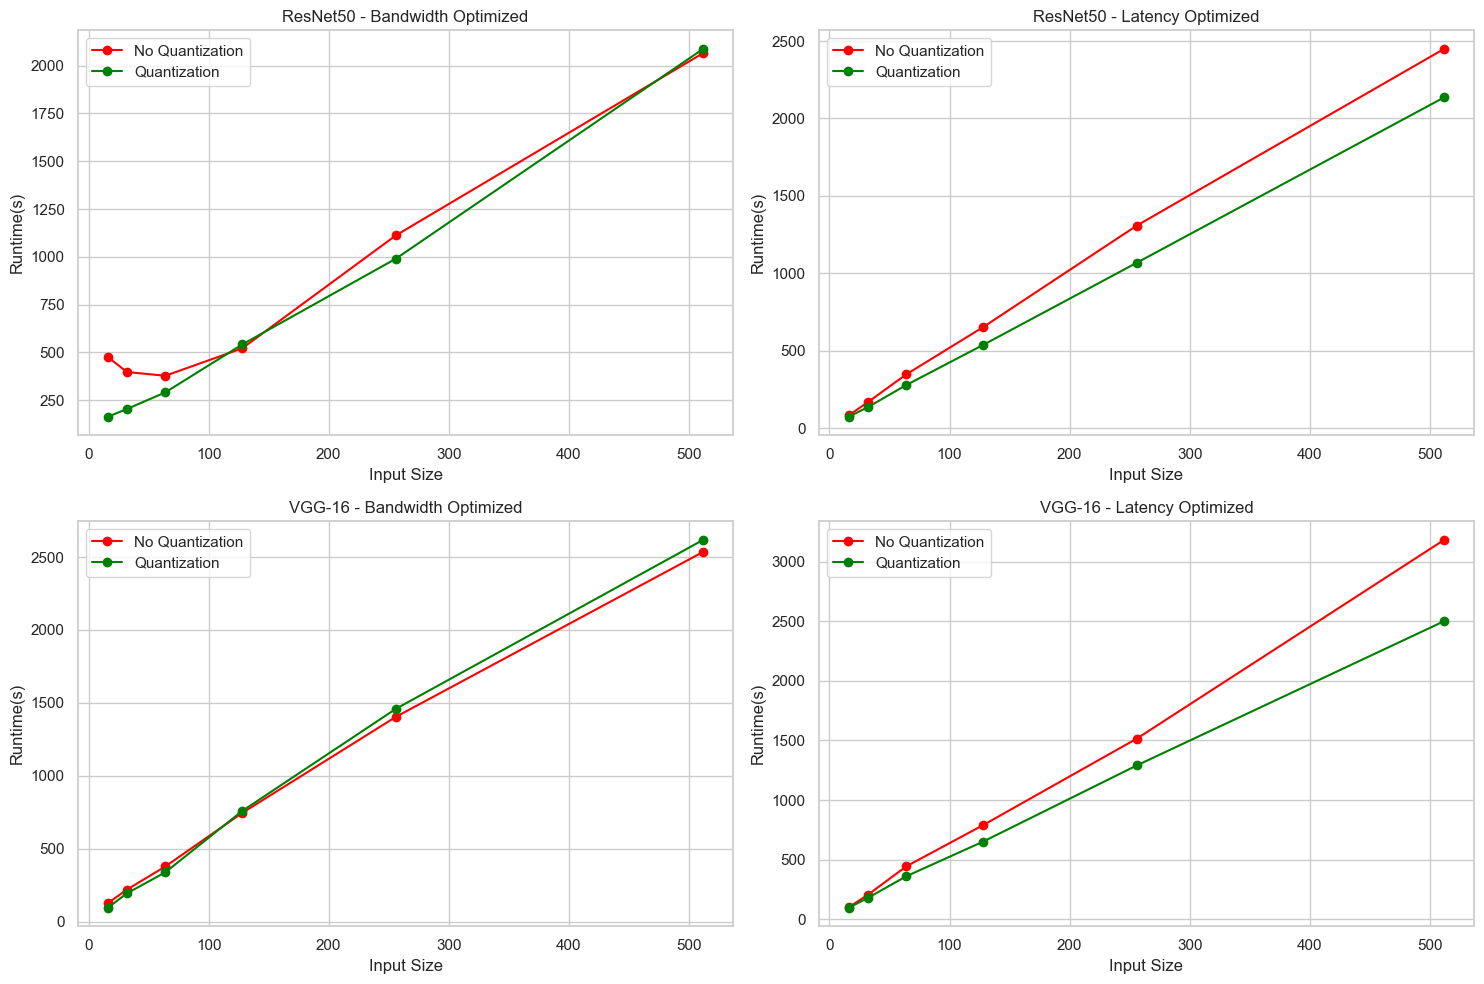

In [150]:
import pandas as pd
import matplotlib.pyplot as plt


def preprocess_runtime(value):
    if isinstance(value, str):
        # Remove all dots and convert the last three digits to milliseconds if necessary
        parts = value.split('.')
        if len(parts) > 1:
            # Combine all parts without dots and interpret the last three digits as milliseconds
            combined = ''.join(parts)
            milliseconds = int(combined) / 1000.0  # Convert to milliseconds
        else:
            milliseconds = float(value) * 1000  # Convert seconds to milliseconds
    else:
        milliseconds = value * 1000  # Assume float values are in seconds, convert to milliseconds
    
    return milliseconds

# Load the CSV file
df = pd.read_csv('Quantization_results.csv', sep=';')
# Apply the preprocessing to 'runtime_external(s)' column
df['runtime_chrono(s)'] = df['runtime_chrono(s)'].apply(preprocess_runtime)
df['input_size'] = df['input_size']*16
# Continue with your plotting code...





# Apply the preprocessing to 'runtime_external(s)' column
#df['runtime_external(s)'] = df['runtime_external(s)'].apply(preprocess_runtime)


# Mapping function codes to readable names
function_mapping = {
    71: "ResNet50 - Bandwidth Optimized - No Quantization",
    81: "ResNet50 - Latency Optimized - No Quantization",
    171: "ResNet50 - Bandwidth Optimized - Quantization",
    181: "ResNet50 - Latency Optimized - Quantization",
    74: "VGG-16 - Bandwidth Optimized - No Quantization",
    84: "VGG-16 - Latency Optimized - No Quantization",
    174: "VGG-16 - Bandwidth Optimized - Quantization",
    184: "VGG-16 - Latency Optimized - Quantization"
}

# Convert function codes to readable names
df['Configuration'] = df['function'].map(function_mapping)

# Splitting configurations for ResNet50 and VGG-16
configs = {
    'ResNet50 - Bandwidth Optimized': ['ResNet50 - Bandwidth Optimized - No Quantization', 'ResNet50 - Bandwidth Optimized - Quantization'],
    'ResNet50 - Latency Optimized': ['ResNet50 - Latency Optimized - No Quantization', 'ResNet50 - Latency Optimized - Quantization'],
    'VGG-16 - Bandwidth Optimized': ['VGG-16 - Bandwidth Optimized - No Quantization', 'VGG-16 - Bandwidth Optimized - Quantization'],
    'VGG-16 - Latency Optimized': ['VGG-16 - Latency Optimized - No Quantization', 'VGG-16 - Latency Optimized - Quantization']
}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, (config_name, config_list) in enumerate(configs.items()):
    for config in config_list:
        # Ensure data is sorted by 'input_size'
        group = df[df['Configuration'] == config].sort_values(by='input_size')
        color = 'red' if 'No Quantization' in config else 'green'
        axs[i].plot(group['input_size'], group['runtime_chrono(s)'], 'o-', color=color, label=config.split(' - ')[2])
    axs[i].set_title(config_name)
    axs[i].set_xlabel('Input Size')
    axs[i].set_ylabel('Runtime(s)')
    axs[i].legend()

plt.tight_layout()
plt.show()


FIND THE CORRESPONDING runs


In [151]:

# Define the directory where your .loop and CSV files are located

import os
import csv
import json
from json.decoder import JSONDecodeError

# Define the directory where your .loop and CSV files are located
directory_path = '/Users/mervekilicarslan/Desktop/quantization_logs/meld'


# Define the values you want to match in the .loop files
loop_values_to_match = {
    "ssl": 0,
    "function": 184,
    "packbool": 1,
    "protocol": 5,
    "rxbuffer": 10000,
    "txbuffer": 10000,
    "input_size": 32
}

# Function to read values from a .loop file
def read_loop_file(loop_file):
    with open(loop_file, 'r') as f:
        loop_data = json.load(f)
    return loop_data

# Function to check if two dictionaries match based on specified values
def dictionaries_match(dict1, dict2):
    for key, value in loop_values_to_match.items():
        if key not in dict1 or dict1[key] != value:
            return False
    return True

def extract_run_number(loop_file):
    file_name = os.path.splitext(loop_file)[0]
    # Split the filename by underscores and extract the last part
    parts = file_name.split('_')
    run_number = parts[-1]
    return run_number


# Iterate through .loop files and find matching values
for loop_file in os.listdir(directory_path):
    if loop_file.endswith('.loop'):
        loop_path = os.path.join(directory_path, loop_file)
        loop_data = read_loop_file(loop_path)
        
        if dictionaries_match(loop_data, loop_values_to_match):
            print(f"Matching .loop file: {loop_file}")
            run_number = extract_run_number(loop_file)
            csv_file_name = f'testresults_{run_number}.csv'
            csv_file_path = os.path.join(directory_path, csv_file_name)
            break
    
if os.path.isfile(csv_file_path):
    print(f"Corresponding CSV file: {csv_file_name}")
            # Now you can proceed to plot values from the CSV file
            # You can add your code to plot values here
else:
    print(f"CSV file not found for .loop file: {loop_file}")

Matching .loop file: 2024-01-26_03-48-09_746573_unknown_run95.loop
Corresponding CSV file: testresults_run95.csv


for the bandwitdh check the total communication for th conv layer because we have an extra multoplication that is why. TOTAL COMM HIGHER WITH QUNATIZATION. 
2 operation s with 8 bit another 32 bit operation.

In [89]:
vgg_lat_q= 'testresults_run95.csv'
vgg_lat = 'testresults_run65.csv'
vgg_band_q='testresults_run83.csv'
vgg_band ='testresults_run53.csv'

res_lat_q='testresults_run47.csv'
res_lat='testresults_run17.csv'
res_band_q='testresults_run35.csv'
res_band ='testresults_run05.csv'

save_dir = './stats/layers'

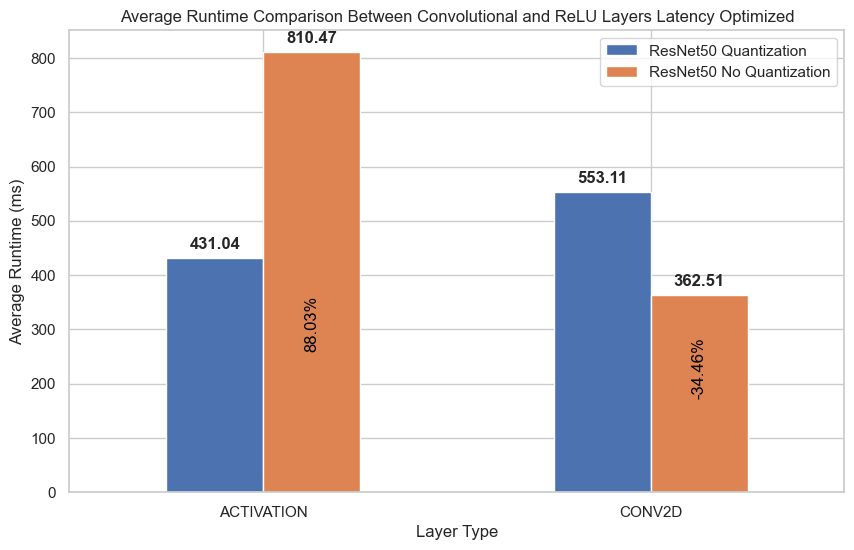

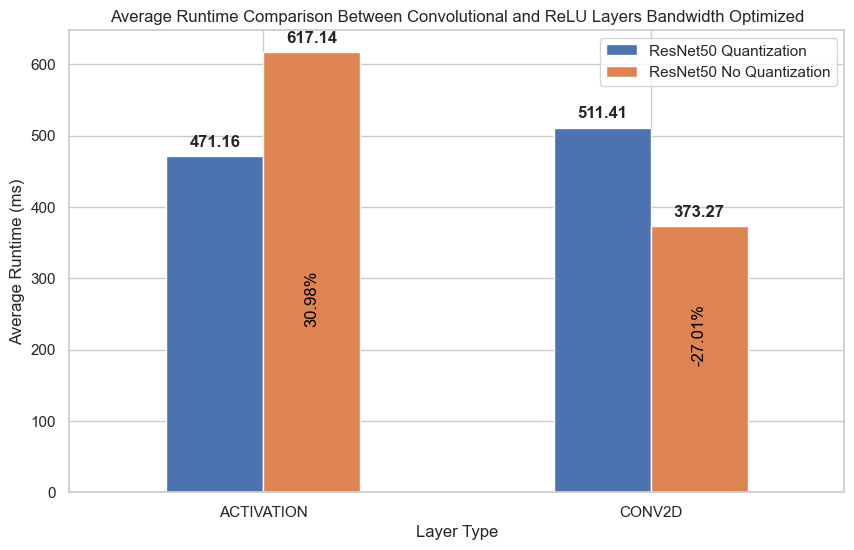

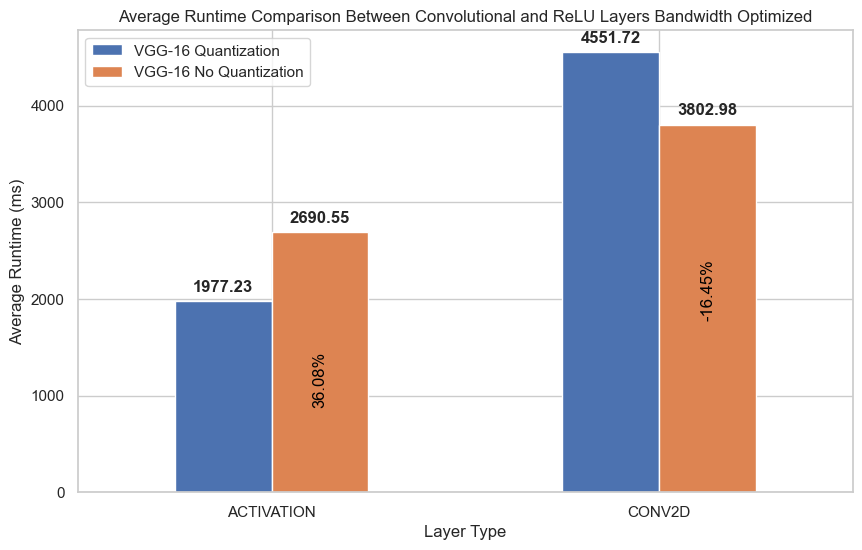

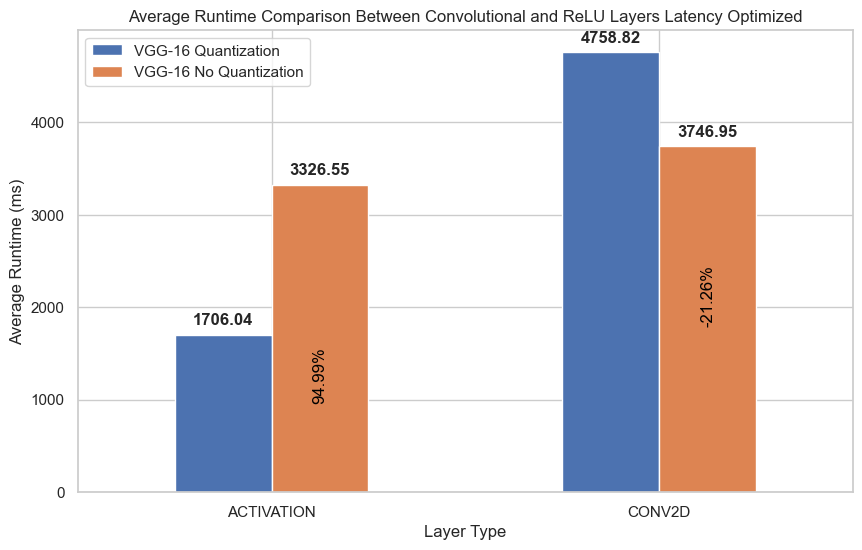

In [155]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_average_runtime_comparison(directory_path, file1, file2, layer_types=['CONV2D', 'ACTIVATION'], 
                                    plot_title='Average Runtime Comparison Between Convolutional and ReLU Layers Latency Optimized',
                                      y_label='Average Runtime (ms)', x_label='Layer Type', 
                                      legend_labels=['ResNet50 Quantization', 'ResNet50 No Quantization'],
                                      file_name = 'filename'):
    # Generate full paths to the files
    file1_path = os.path.join(directory_path, file1)
    file2_path = os.path.join(directory_path, file2)

    # Load the data from CSV files
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Filter the DataFrames for specified layer types
    conv_relu_df1 = df1[df1['LayerType'].isin(layer_types)]
    conv_relu_df2 = df2[df2['LayerType'].isin(layer_types)]

    # Group by LayerType and calculate the average runtime
    avg_runtime_df1 = conv_relu_df1.groupby('LayerType')['MS Live'].mean().reset_index()
    avg_runtime_df2 = conv_relu_df2.groupby('LayerType')['MS Live'].mean().reset_index()

    # Prepare data for plotting
    avg_runtime_df = pd.merge(avg_runtime_df1, avg_runtime_df2, on='LayerType', suffixes=('_File1', '_File2'))
    avg_runtime_df.set_index('LayerType', inplace=True)

    # Calculate the percentage difference between the two files for each layer
    avg_runtime_df['Percent Difference'] = ((avg_runtime_df['MS Live_File2'] - avg_runtime_df['MS Live_File1']) / avg_runtime_df['MS Live_File1']) * 100

    # Calculate the min and max values from both datasets
    avg_runtime_df['Min Value'] = conv_relu_df1.groupby('LayerType')['MS Live'].min().combine(conv_relu_df2.groupby('LayerType')['MS Live'].min(), min)
    avg_runtime_df['Max Value'] = conv_relu_df1.groupby('LayerType')['MS Live'].max().combine(conv_relu_df2.groupby('LayerType')['MS Live'].max(), max)

    # Plot the data
    ax = avg_runtime_df[['MS Live_File1', 'MS Live_File2']].plot(kind='bar', figsize=(10, 6))
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xticks(rotation=0)
    plt.legend(legend_labels)



    # Adjust the annotation of percentage differences
    for idx, row in avg_runtime_df.iterrows():
        idx_location = ax.patches[len(avg_runtime_df) + avg_runtime_df.index.get_loc(idx)].get_x() + ax.patches[len(avg_runtime_df) + avg_runtime_df.index.get_loc(idx)].get_width() / 2.
        mid_height = (row['MS Live_File1'] + row['MS Live_File2']) / 2  # Average height of the two bars
        plt.text(idx_location, mid_height * 0.5, f'{row["Percent Difference"]:.2f}%', ha='center', va='center', color='black', rotation=90, fontsize=12)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontweight='bold')

    if file_name:
        plt.savefig(os.path.join('./stats/layers', file_name))
    plt.show()



# Example usage:
plot_average_runtime_comparison(directory_path, res_lat_q, res_lat,plot_title='Average Runtime Comparison Between Convolutional and ReLU Layers Latency Optimized', 
                                legend_labels=['ResNet50 Quantization', 'ResNet50 No Quantization'],file_name='run_lat_res')
plot_average_runtime_comparison(directory_path, res_band_q, res_band, plot_title='Average Runtime Comparison Between Convolutional and ReLU Layers Bandwidth Optimized',
                                legend_labels=['ResNet50 Quantization', 'ResNet50 No Quantization'], file_name='run_band_res')
plot_average_runtime_comparison(directory_path, vgg_band_q, vgg_band, plot_title='Average Runtime Comparison Between Convolutional and ReLU Layers Bandwidth Optimized',
                                legend_labels=['VGG-16 Quantization', 'VGG-16 No Quantization'], file_name='run_band_vgg16')
plot_average_runtime_comparison(directory_path, vgg_lat_q, vgg_lat,plot_title='Average Runtime Comparison Between Convolutional and ReLU Layers Latency Optimized',
                                legend_labels=['VGG-16 Quantization', 'VGG-16 No Quantization'], file_name='run_lat_vgg16')


In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_runtime_table_image(directory_path, file_label_map, layer_types=['CONV2D', 'ACTIVATION']):

    mean_runtimes = {}
    # Load data from each file and calculate mean runtimes
    for file, label in file_label_map.items():
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        for layer_type in layer_types:
            if layer_type not in mean_runtimes:
                mean_runtimes[layer_type] = {}
            filtered_df = df[df['LayerType'] == layer_type]
            if not filtered_df.empty:
                mean_runtime = filtered_df['MS Live'].astype(float).mean()
                mean_runtimes[layer_type][label] = mean_runtime  # Store unformatted mean

    # Create a DataFrame and plot for each layer type
    image_paths = {}
    for layer_type, runtimes in mean_runtimes.items():
        if runtimes:  # Check if there is data to process
            table = pd.DataFrame.from_dict(runtimes, orient='index', columns=[f'Mean Runtime ({layer_type})'])
            table.sort_index(inplace=True)  # Optional: sort by index if needed
            table.rename_axis('Configuration', inplace=True)
            table.reset_index(inplace=True)
            # Apply numerical formatting here
            table[f'Mean Runtime ({layer_type})'] = table[f'Mean Runtime ({layer_type})'].map('{:.2f}'.format)

            # Plotting the DataFrame as a table
            fig, ax = plt.subplots(figsize=(8, 1 + 0.5 * len(table)))
            ax.axis('tight')
            ax.axis('off')
            table_plot = ax.table(cellText=table.values, colLabels=table.columns, loc='center', cellLoc='center', colWidths=[0.4, 0.4])
            table_plot.auto_set_font_size(False)
            table_plot.set_fontsize(10)
            table_plot.scale(1, 1.4)  # Adjust column width and row height

             # Coloring rows
            for i, key in enumerate(table_plot.get_celld().keys()):
                if key[0] == 0 or 3 <= key[0] <= 4 or 7 <= key[0] <= 8:
                    cell = table_plot[key]
                    cell.set_facecolor('gray')
                if key[0] == 0:
                    cell.set_text_props(weight='bold')

            # Save the table as an image
            image_path = os.path.join('./stats/layers', f"{layer_type}_runtime_table.png")
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            plt.close()
            image_paths[layer_type] = image_path
        else:
            print(f"No data available for {layer_type}, skipping table generation.")

    return image_paths


file_label_map = {
    'testresults_run95.csv': 'VGG-16 Latency Opt. Quantized',
    'testresults_run65.csv': 'VGG-16 Latency Opt. ',
    'testresults_run83.csv': 'VGG-16 Bandwith Opt. Quantized',
    'testresults_run53.csv': 'VGG-16 Bandwith Opt.',
    'testresults_run47.csv': 'ResNet50 Latency Opt. Quantized',
    'testresults_run17.csv': 'ResNet50 Latency Opt.',
    'testresults_run35.csv': 'ResNet50 Bandwidth Opt. Quantized',
    'testresults_run05.csv': 'ResNet50 Bandwidth Opt. ' 
}

image_paths = create_runtime_table_image(directory_path, file_label_map)



PLOTS FOR THE NETWORK SETTINGS

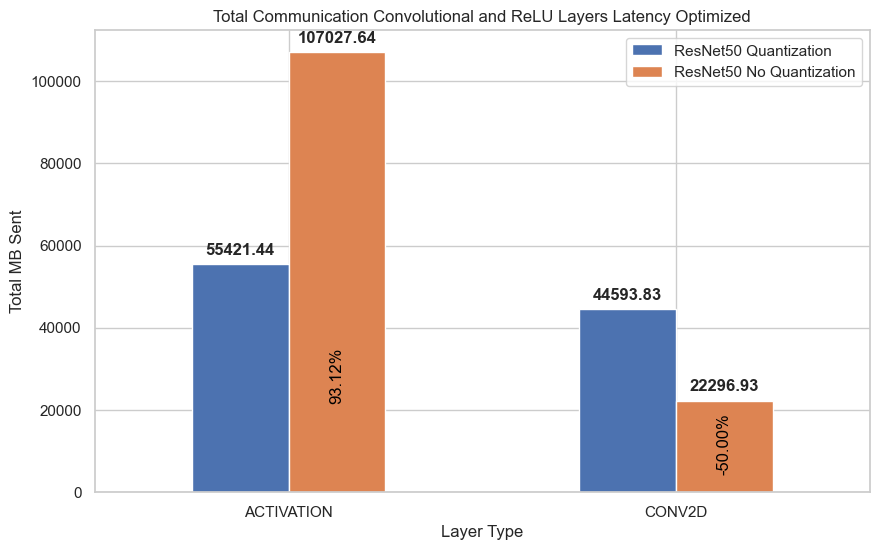

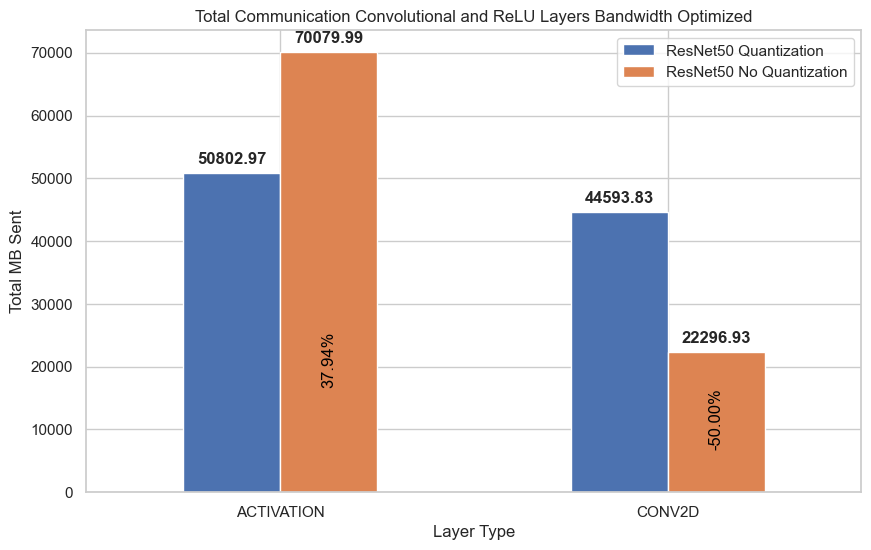

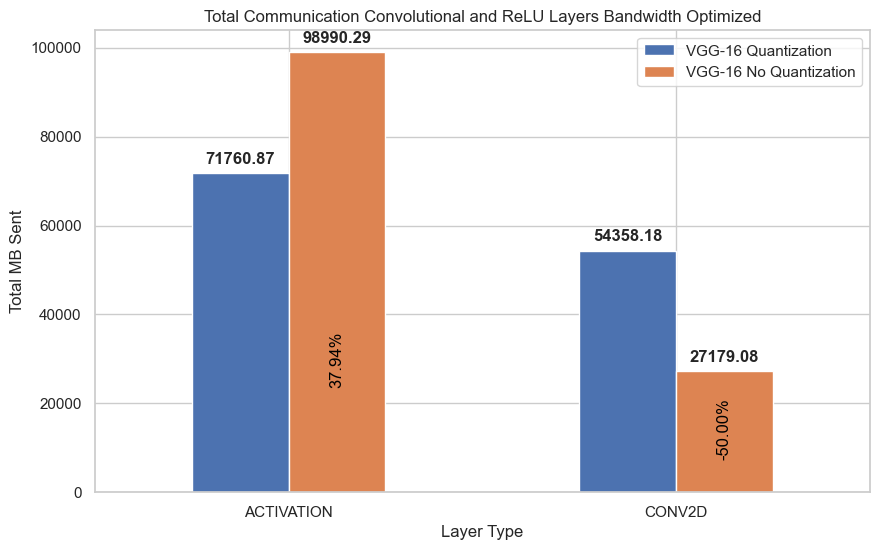

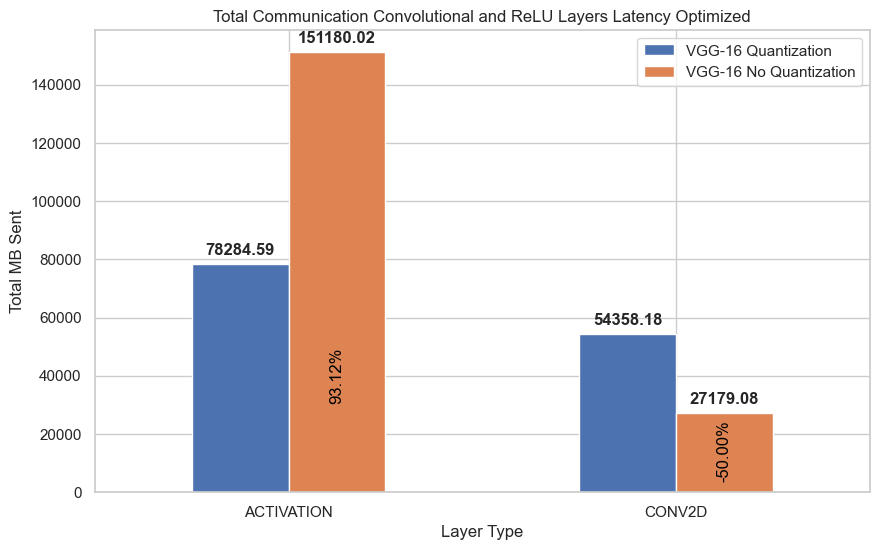

In [174]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_communication_comparison(directory_path, file1, file2,
                                  plot_title='Total Communication for Convolutional and ReLU Layers',
                                  legend_labels=['VGG16 Quantization', 'VGG16 No Quantization'],
                                  file_name='x'):
    
    file1_path = os.path.join(directory_path, file1)
    file2_path = os.path.join(directory_path, file2)

    # Load the data from CSV files
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # Filter for CONV2D and ACTIVATION layers
    conv_relu_df1 = df1[df1['LayerType'].isin(['CONV2D', 'ACTIVATION'])]
    conv_relu_df2 = df2[df2['LayerType'].isin(['CONV2D', 'ACTIVATION'])]

    # Sum the 'MB Sent' for each layer type to get the total communication
    total_comm_df1 = conv_relu_df1.groupby('LayerType')['MB Sent'].sum().reset_index()
    total_comm_df2 = conv_relu_df2.groupby('LayerType')['MB Sent'].sum().reset_index()

    # Merge the two DataFrames for comparison
    total_comm_comparison_df = pd.merge(total_comm_df1, total_comm_df2, on='LayerType', suffixes=('_File1', '_File2'))
    
    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    total_comm_comparison_df.set_index('LayerType').plot(kind='bar', ax=ax)
    plt.title(plot_title)
    plt.ylabel('Total MB Sent')
    plt.xlabel('Layer Type')
    plt.xticks(rotation=0)  # Ensure x-tick labels are clear
    plt.legend(legend_labels)
    total_comm_comparison_df['Percent Difference'] = ((total_comm_comparison_df['MB Sent_File2'] - total_comm_comparison_df['MB Sent_File1']) / total_comm_comparison_df['MB Sent_File1']) * 100




    # Adjust the annotation of percentage differences
    for idx, row in total_comm_comparison_df.iterrows():
        idx_location = ax.patches[len(total_comm_comparison_df) + total_comm_comparison_df.index.get_loc(idx)].get_x() + ax.patches[len(total_comm_comparison_df) + total_comm_comparison_df.index.get_loc(idx)].get_width() / 2.
        mid_height = (row['MB Sent_File1'] + row['MB Sent_File2']) / 2
        plt.text(idx_location, mid_height * 0.35, f'{row["Percent Difference"]:.2f}%', ha='center', va='center', color='black', rotation=90, fontsize=12)

    # Annotate each bar with its height
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')



    if file_name:
        plt.savefig(os.path.join('./stats/layers', file_name))
    plt.show()

# Example usage
# Example usage:
plot_communication_comparison(directory_path, res_lat_q, res_lat,plot_title='Total Communication Convolutional and ReLU Layers Latency Optimized', 
                                legend_labels=['ResNet50 Quantization', 'ResNet50 No Quantization'], file_name='comm_lat_resnet')
plot_communication_comparison(directory_path, res_band_q, res_band, plot_title='Total Communication Convolutional and ReLU Layers Bandwidth Optimized',
                                legend_labels=['ResNet50 Quantization', 'ResNet50 No Quantization'], file_name='comm_band_resnet')
plot_communication_comparison(directory_path, vgg_band_q, vgg_band, plot_title='Total Communication Convolutional and ReLU Layers Bandwidth Optimized',
                                legend_labels=['VGG-16 Quantization', 'VGG-16 No Quantization'], file_name='comm_band_vgg16')
plot_communication_comparison(directory_path, vgg_lat_q, vgg_lat,plot_title='Total Communication Convolutional and ReLU Layers Latency Optimized',
                                legend_labels=['VGG-16 Quantization', 'VGG-16 No Quantization'], file_name='comm_lat_vgg16' )



In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
def preprocess_runtime(value):
    if isinstance(value, str):
        # Remove all dots and convert the last three digits to milliseconds if necessary
        parts = value.split('.')
        if len(parts) > 1:
            # Combine all parts without dots and interpret the last three digits as milliseconds
            combined = ''.join(parts)
            milliseconds = int(combined) / 1000.0  # Convert to milliseconds
        else:
            milliseconds = float(value) * 1000  # Convert seconds to milliseconds
    else:
        milliseconds = value * 1000  # Assume float values are in seconds, convert to milliseconds
    
    return milliseconds
# Function and quantization mapping
function_mapping = {
    71: "ResNet50 - Bandwidth Optimized",
    171: "ResNet50 - Balanced",
    271: "ResNet50 - Latency Optimized",
    74: "VGG-16 - Bandwidth Optimized",
    174: "VGG-16 - Balanced",
    274: "VGG-16 - Latency Optimized"
}
# File paths
file_paths = {
    'bandwidth': ('result_bandwith.csv', 'bandwidths(Mbs)'),
    'latency': ('result_latency.csv', 'latencies(ms)'),
    'packet_drop': ('result_packetdrops.csv', 'packetdrops(%)')
}
# Load the data and apply preprocessing
data_frames = {}
for key, value in file_paths.items():
    df = pd.read_csv(value[0], sep=';')
    # Apply the preprocessing to 'runtime_chrono(s)' column
    df['runtime_chrono(ms)'] = df['runtime_chrono(s)'].apply(preprocess_runtime)
    # Convert function codes to readable names and adjust for quantization
    df['Configuration'] = df['function'].map(function_mapping)

# Apply quantization status
    df['Quantized'] = df.apply(
    lambda row: "Quantized" if row.get('packbool') == 1 else "Non-Quantized",
    axis=1
)

# Create a new column to combine configuration and quantization status
    df['Combined Configuration'] = df['Configuration'] + " - " + df['Quantized']
    data_frames[key] = df

import matplotlib.pyplot as plt

def plot_with_std(df, x_col, y_col, plot_title, file_name):
    """
    Plot data with shaded areas representing standard deviation.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        x_col (str): The column name for the x-axis.
        y_col (str): The column name for the y-axis.
        plot_title (str): The title for the plot.

    Returns:
        None
    """
    # Initialize plot
    plt.figure(figsize=(12, 6))
    save_dir = './stats/runtimes'
    # Plot data
    for config in df['Combined Configuration'].unique():
        config_df = df[df['Combined Configuration'] == config]
        plt.plot(config_df[x_col], config_df[y_col], '-o', label=config)

        # Calculate means and standard deviations for each dataset
        grouped = config_df.groupby(x_col)[y_col].agg(['mean', 'std'])
        x_values = grouped.index
        means = grouped['mean']
        std_devs = grouped['std']

        # Plot the standard deviation area around the line
        plt.fill_between(x_values, means - std_devs, means + std_devs, alpha=0.3)

    # Set plot title, x-axis label, y-axis label, grid, and legend
    plt.title(plot_title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if file_name:
        plt.savefig(os.path.join(save_dir, file_name))
    plt.show()



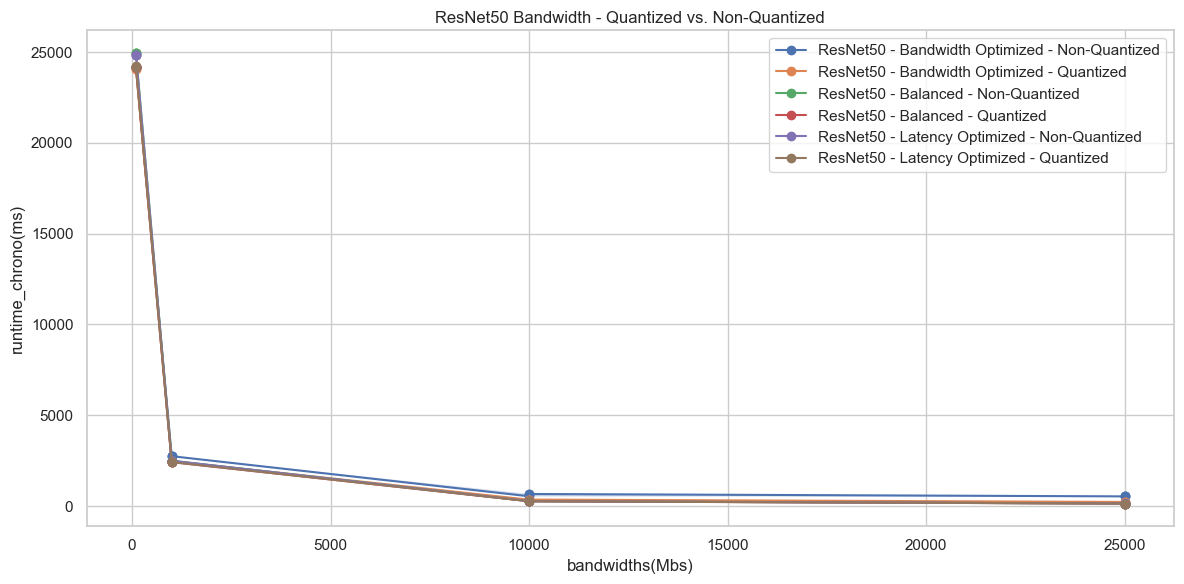

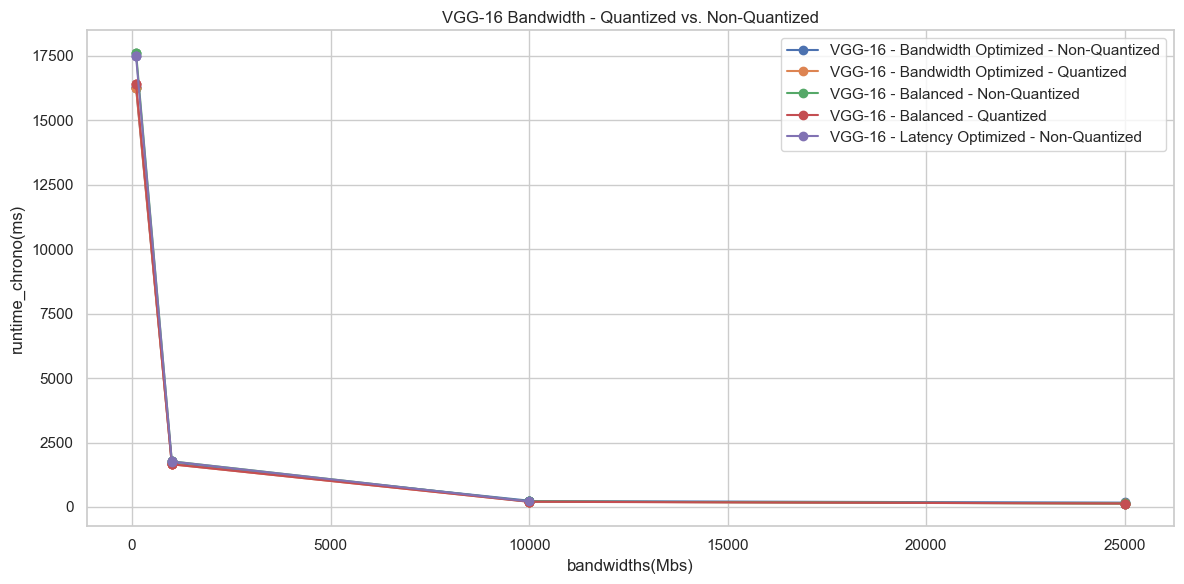

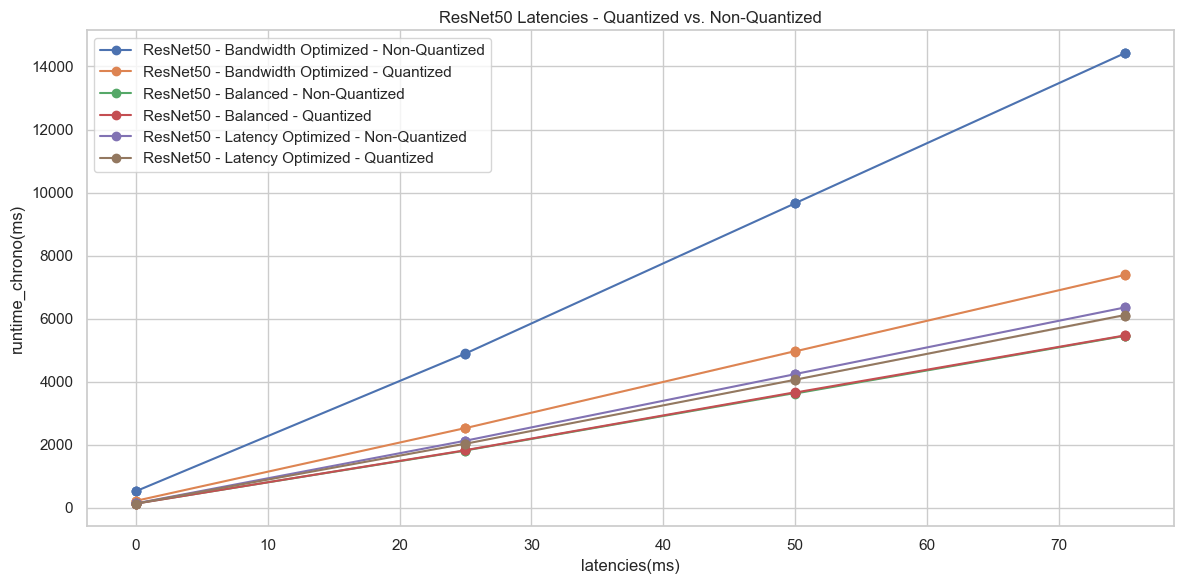

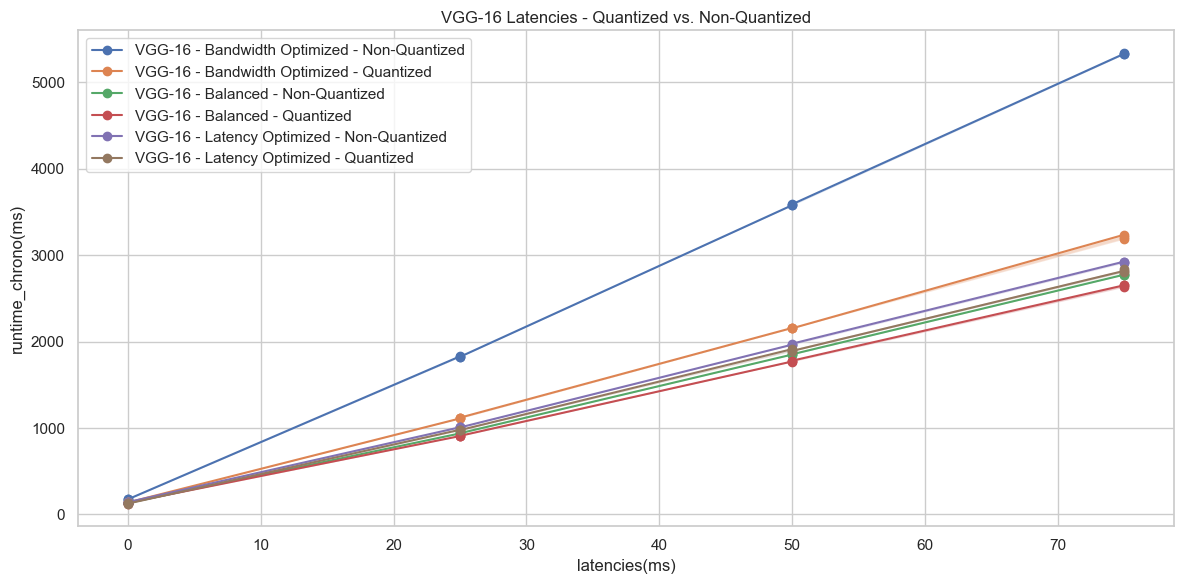

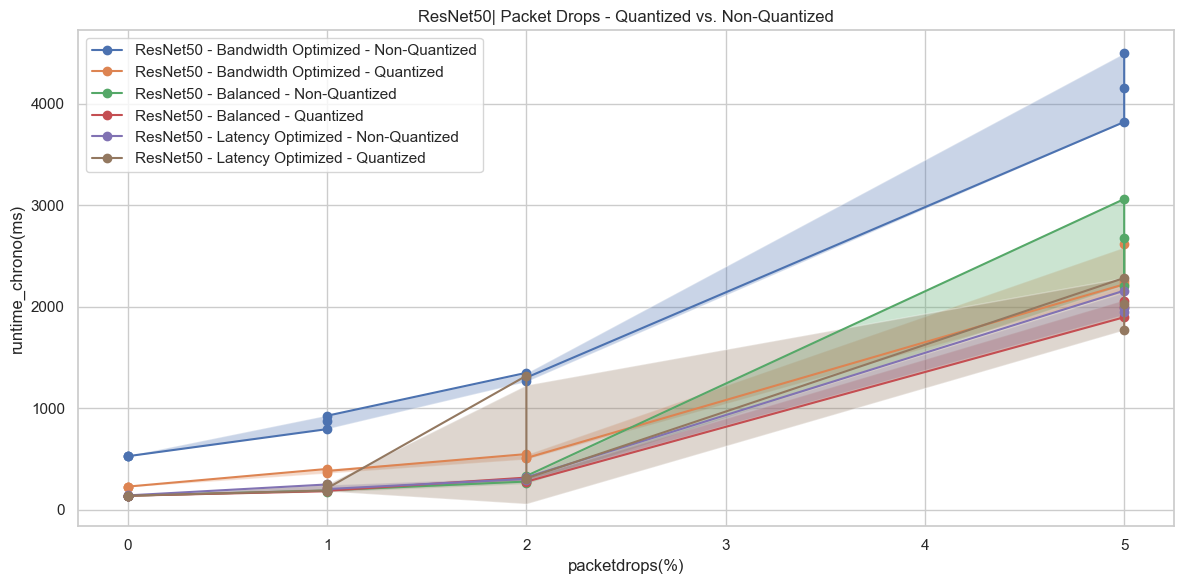

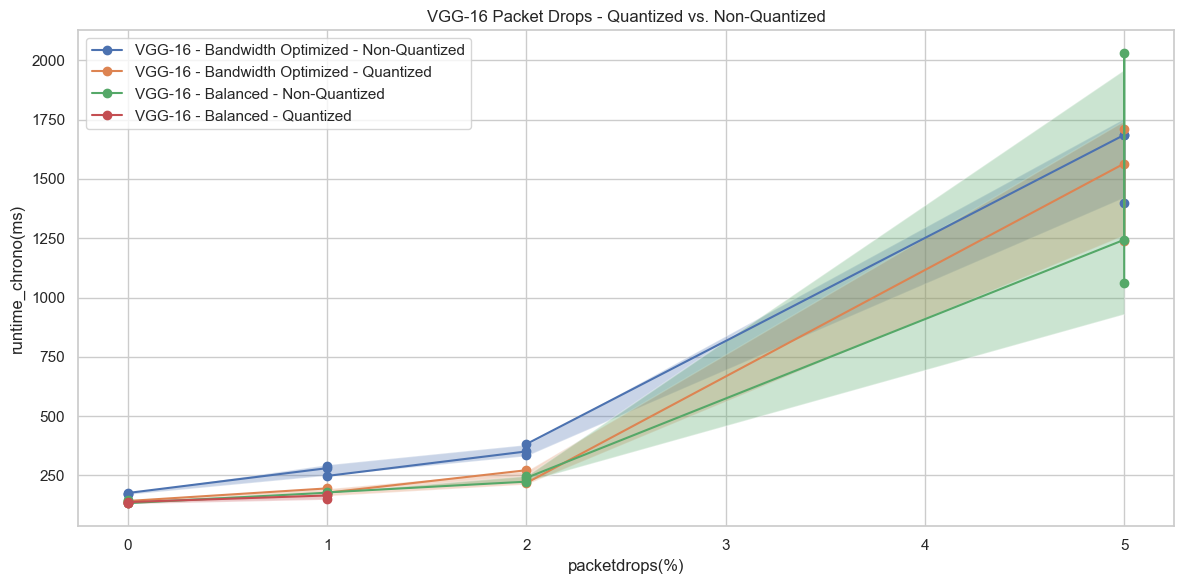

In [200]:


df_band = data_frames['bandwidth']
df_lat = data_frames['latency']
df_packet = data_frames['packet_drop']

df_band_res  = df_band[df_band['Configuration'].str.contains('ResNet50')]
df_band_vgg = df_band[df_band['Configuration'].str.contains('VGG-16')]
df_lat_res  = df_lat[df_lat['Configuration'].str.contains('ResNet50')]
df_lat_vgg = df_lat[df_lat['Configuration'].str.contains('VGG-16')]
df_pac_res  = df_packet [df_packet ['Configuration'].str.contains('ResNet50')]
df_pac_vgg = df_packet [df_packet ['Configuration'].str.contains('VGG-16')]

plot_with_std(df_band_res, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'ResNet50 Bandwidth - Quantized vs. Non-Quantized', 'band_res50')
plot_with_std(df_band_vgg, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'VGG-16 Bandwidth - Quantized vs. Non-Quantized', 'band_vgg16')

plot_with_std(df_lat_res , 'latencies(ms)', 'runtime_chrono(ms)', 'ResNet50 Latencies - Quantized vs. Non-Quantized', 'lat_res50')
plot_with_std(df_lat_vgg, 'latencies(ms)', 'runtime_chrono(ms)', 'VGG-16 Latencies - Quantized vs. Non-Quantized', 'lat_vgg16')


plot_with_std(df_pac_res, 'packetdrops(%)', 'runtime_chrono(ms)', 'ResNet50| Packet Drops - Quantized vs. Non-Quantized', 'pac_res50')
plot_with_std(df_pac_vgg, 'packetdrops(%)', 'runtime_chrono(ms)', 'VGG-16 Packet Drops - Quantized vs. Non-Quantized', 'pac_vgg16')

Individual plots

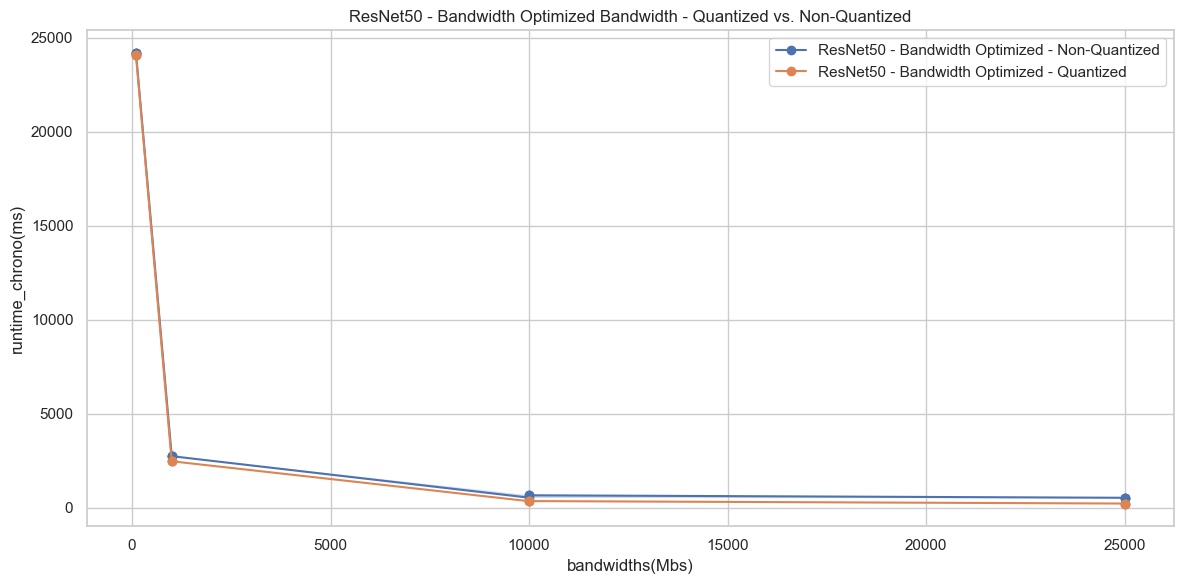

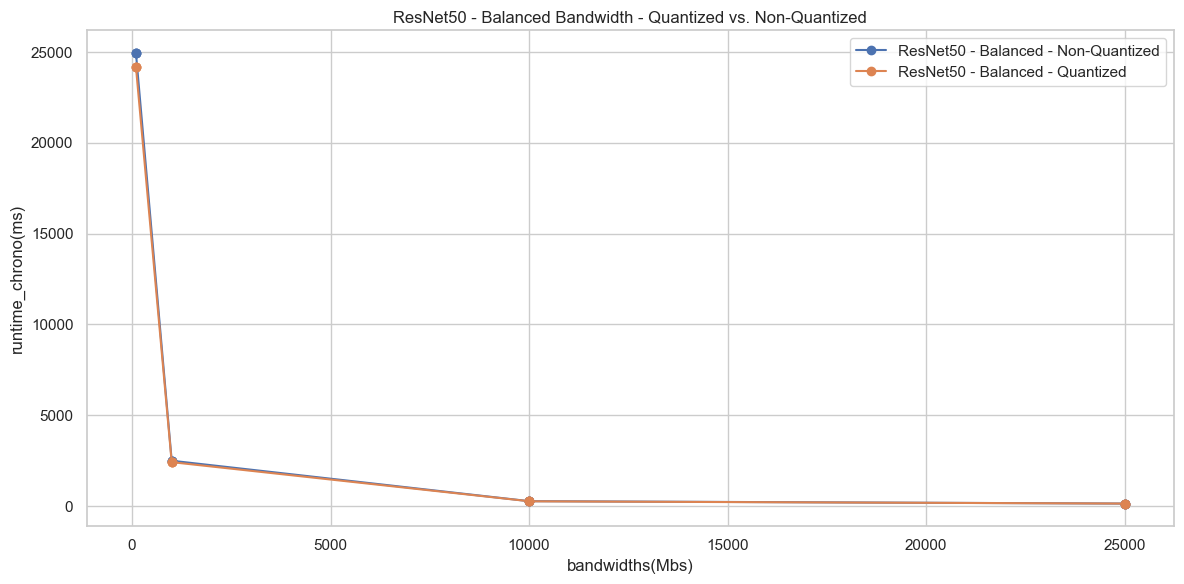

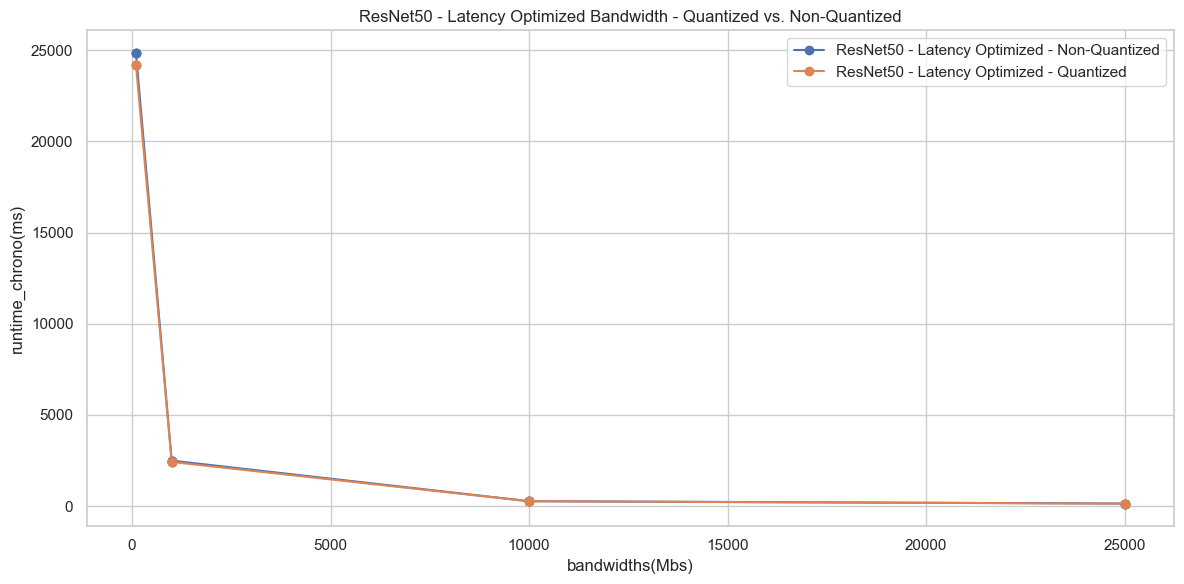

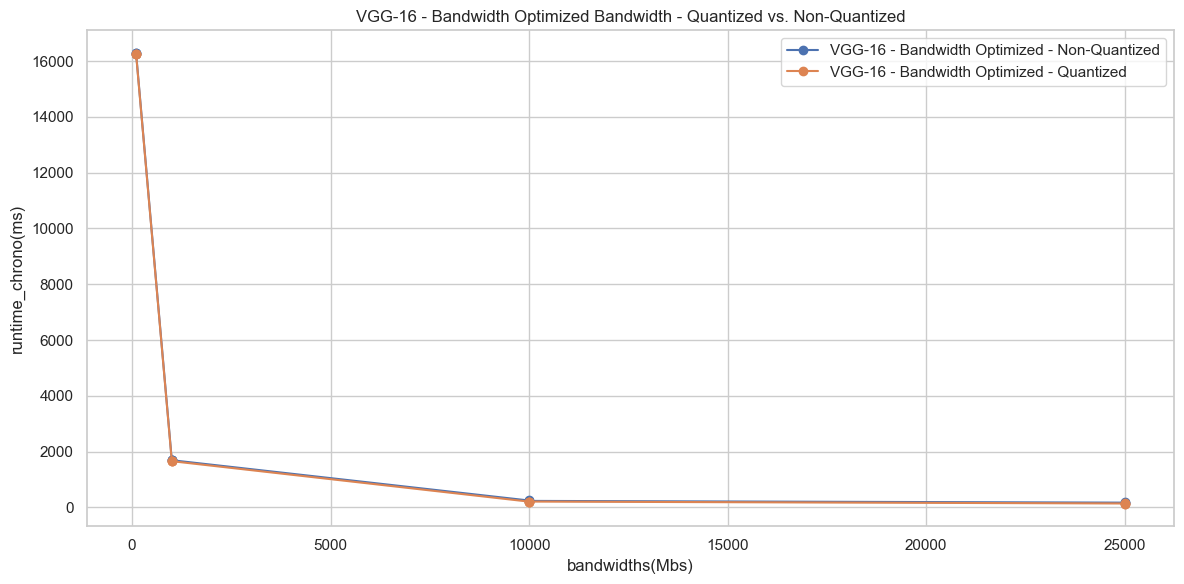

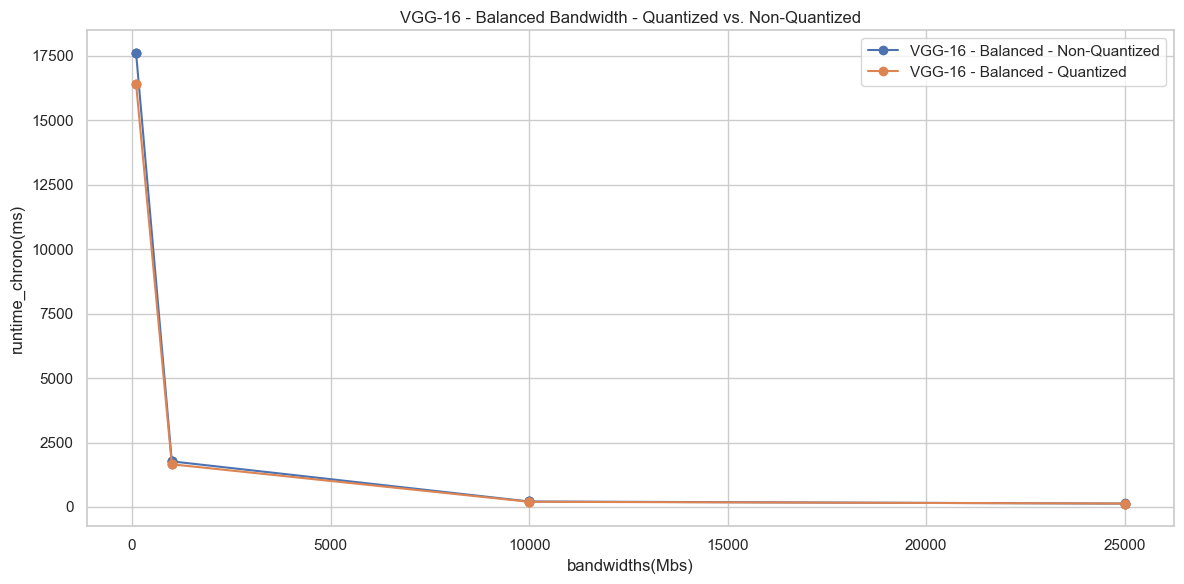

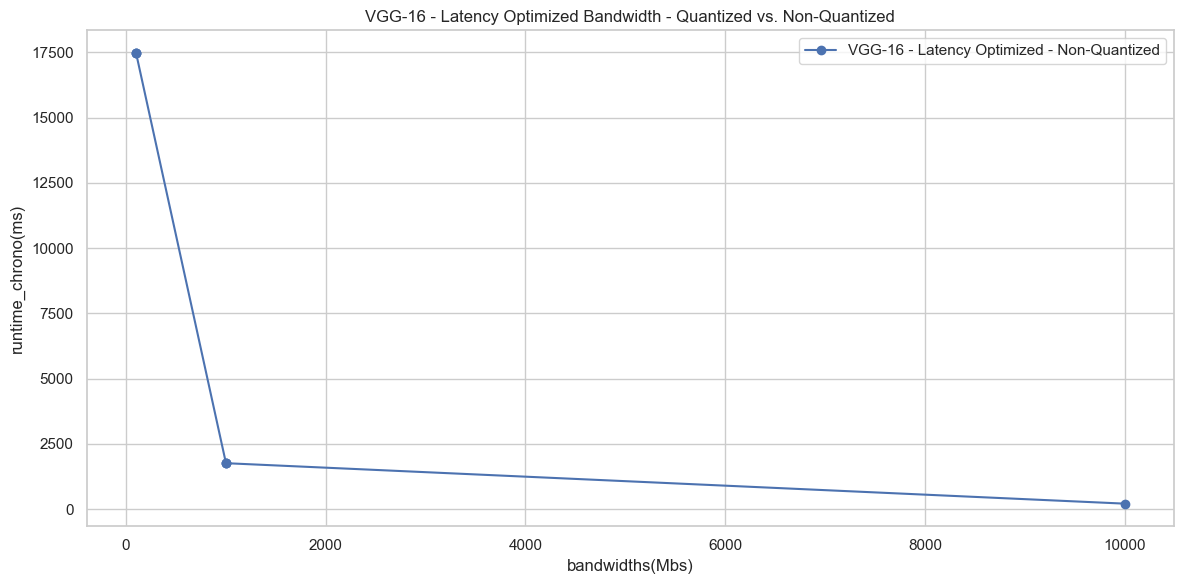

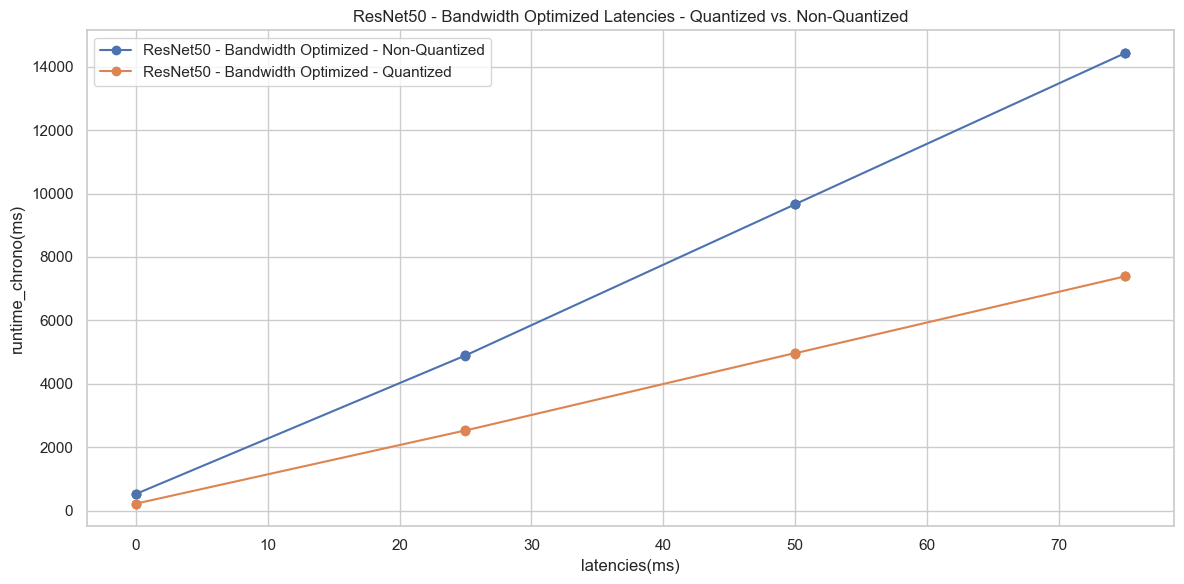

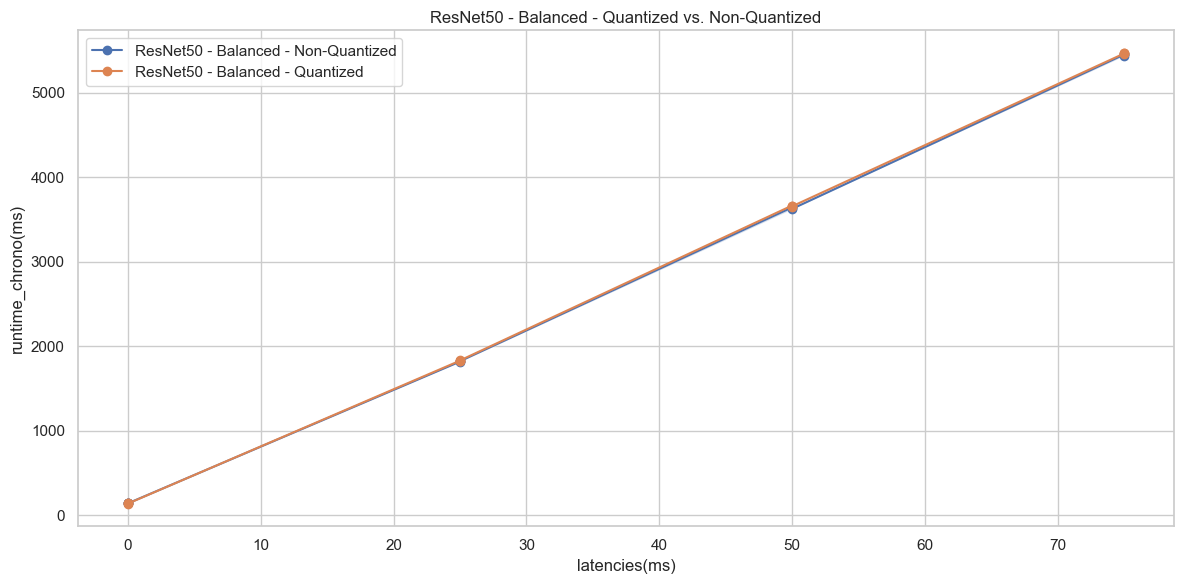

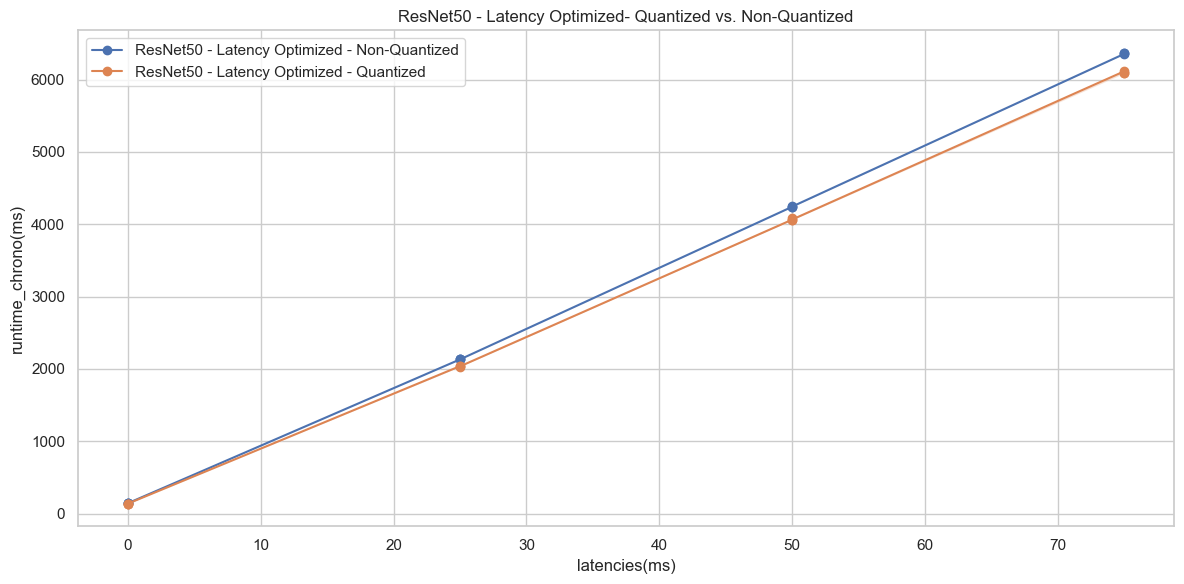

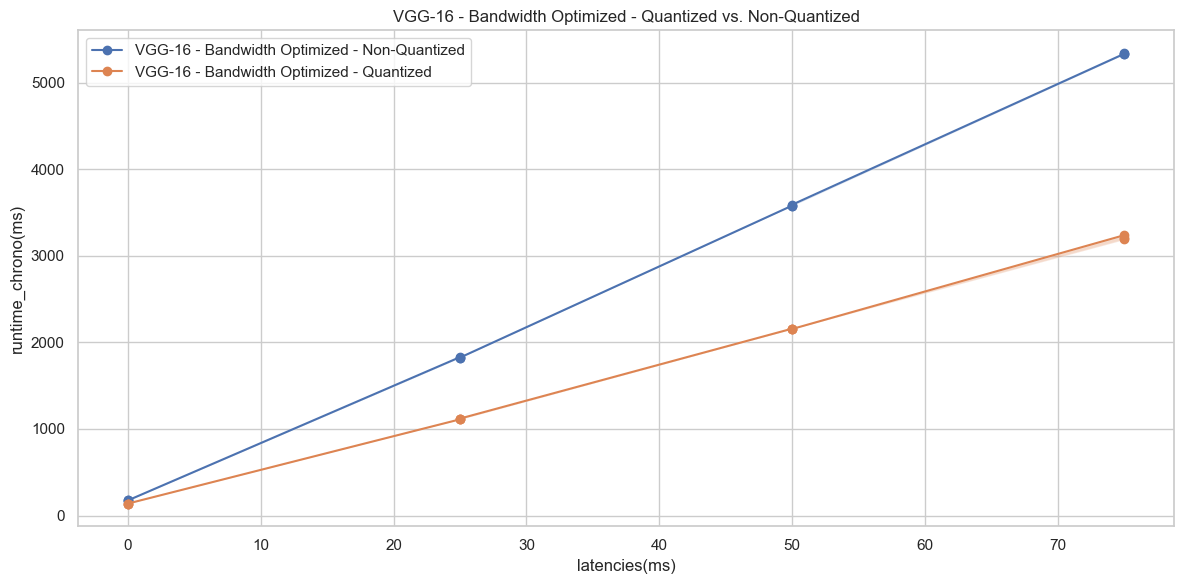

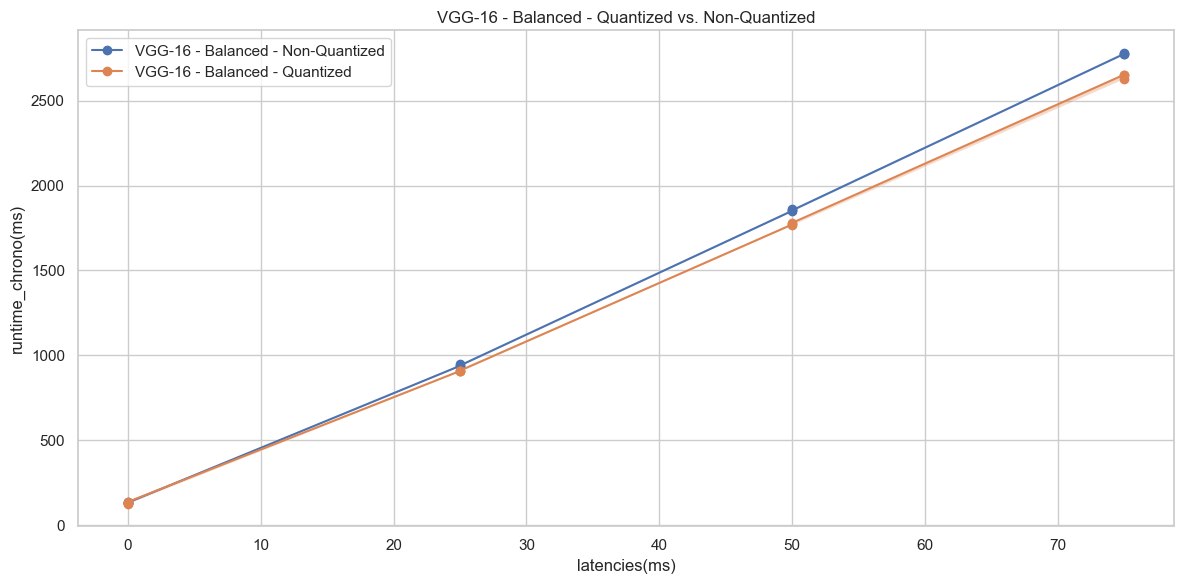

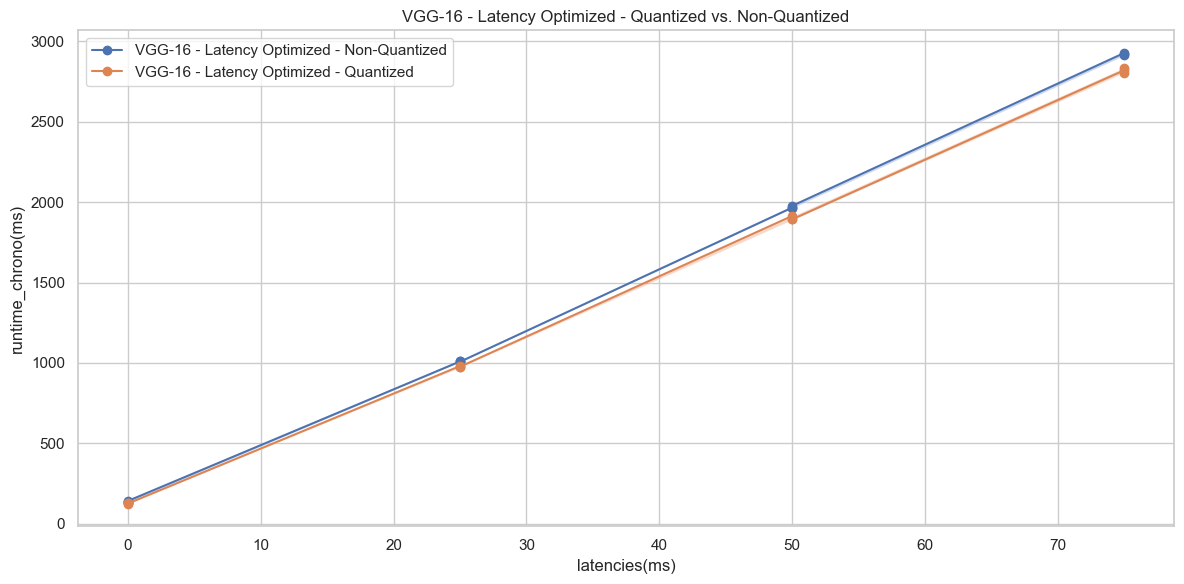

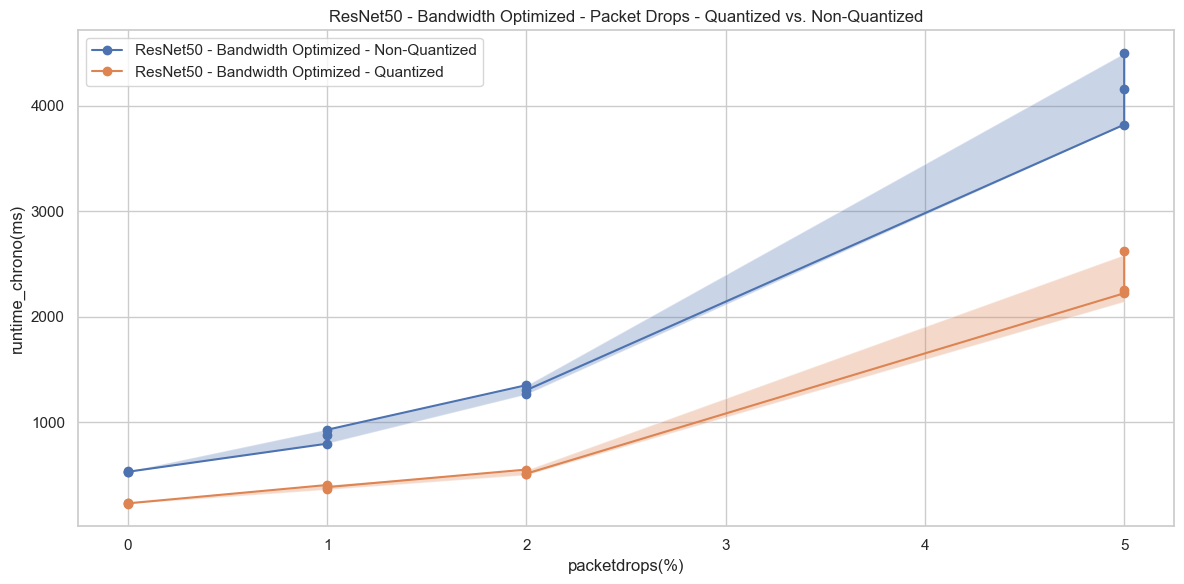

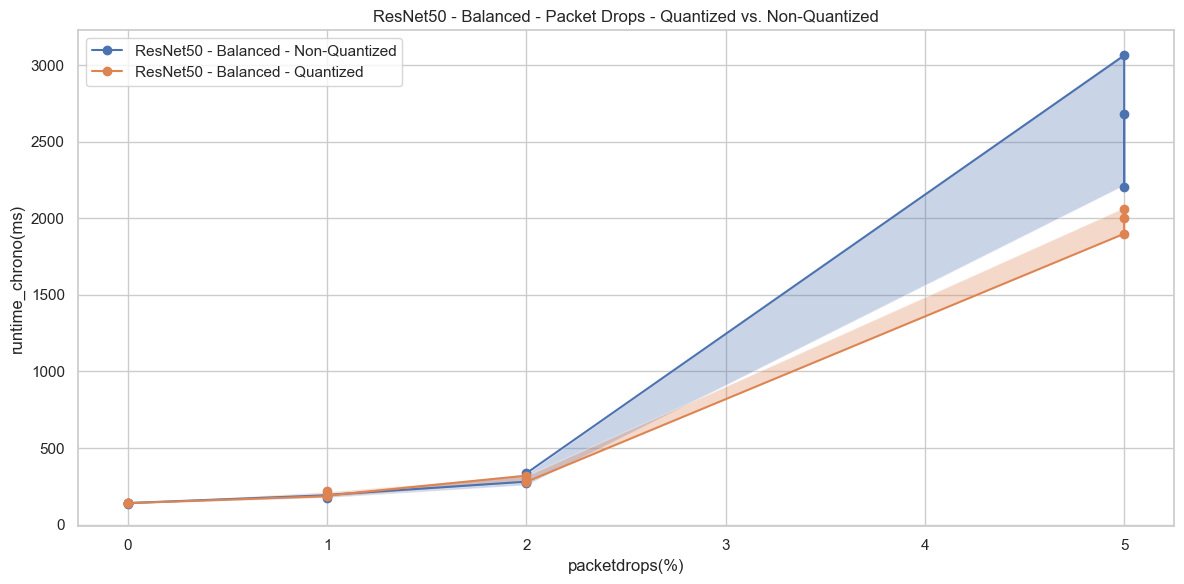

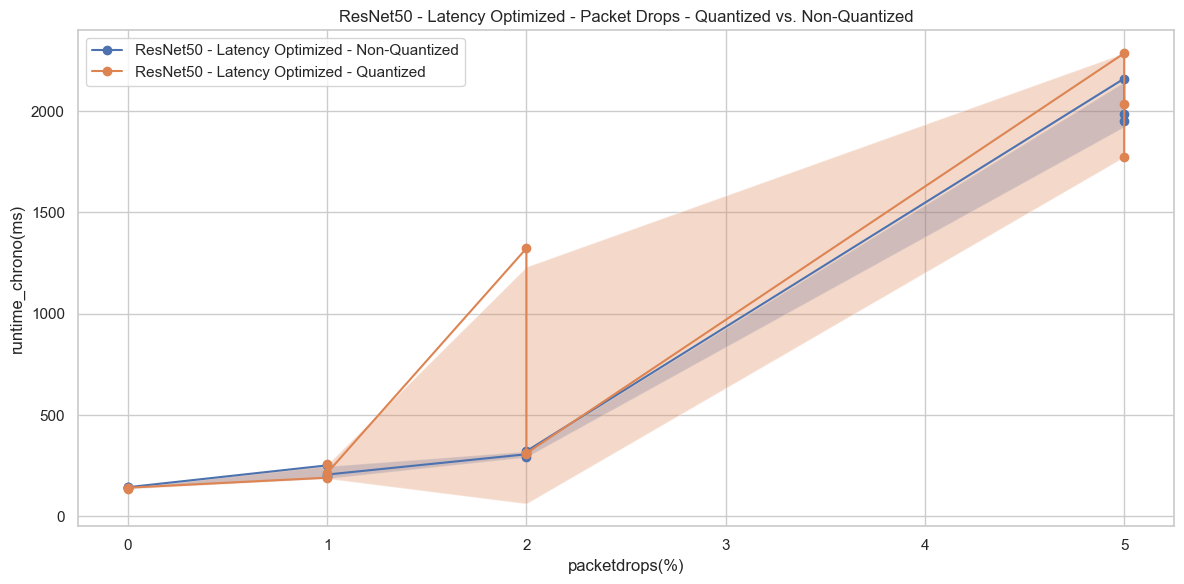

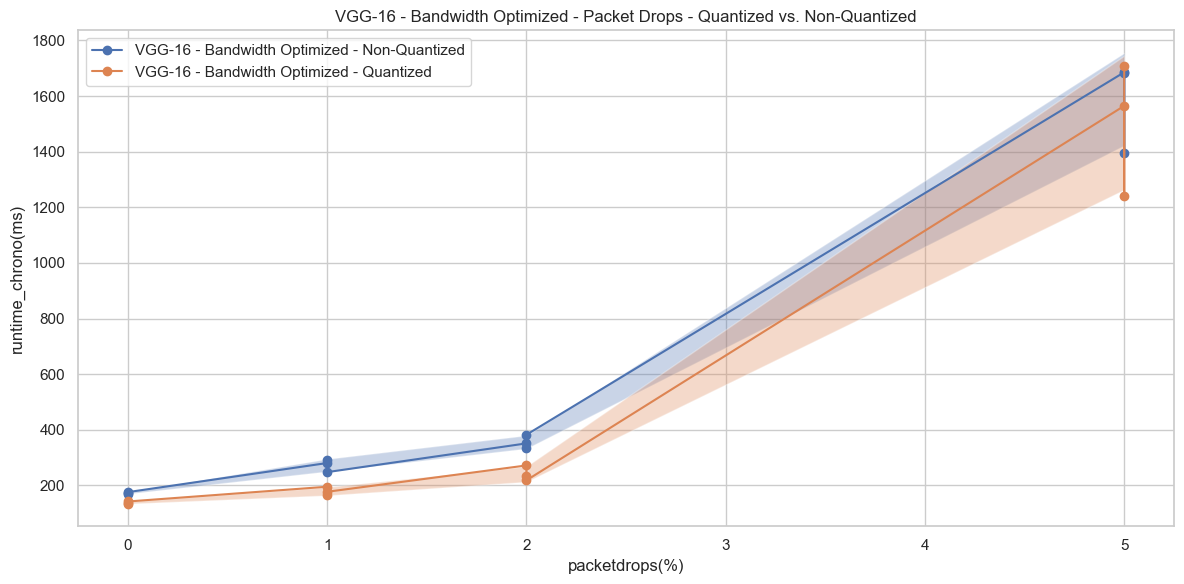

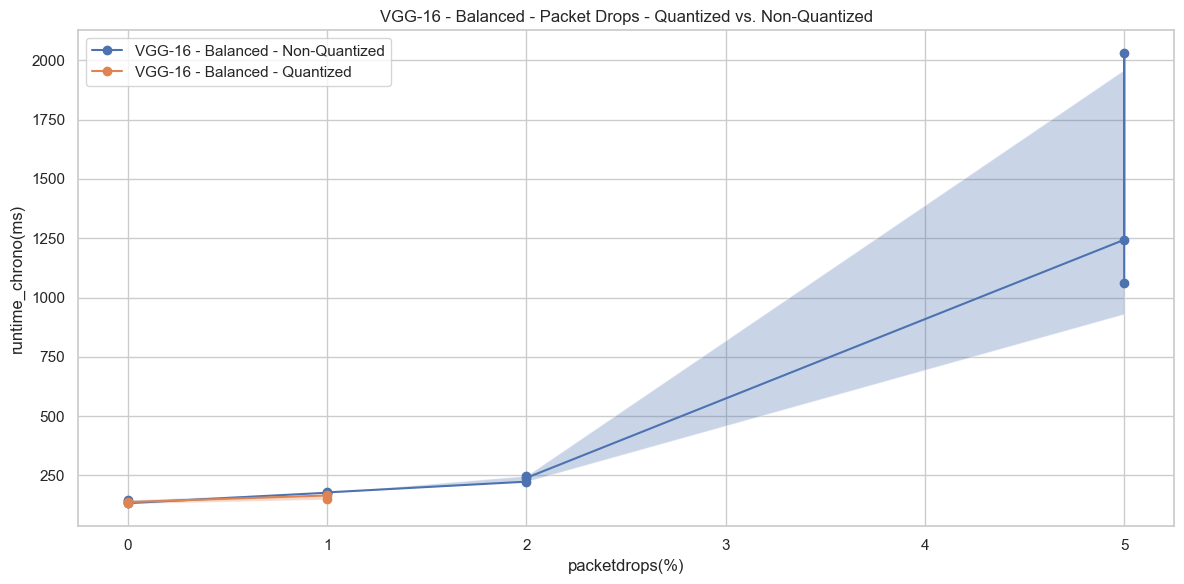

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


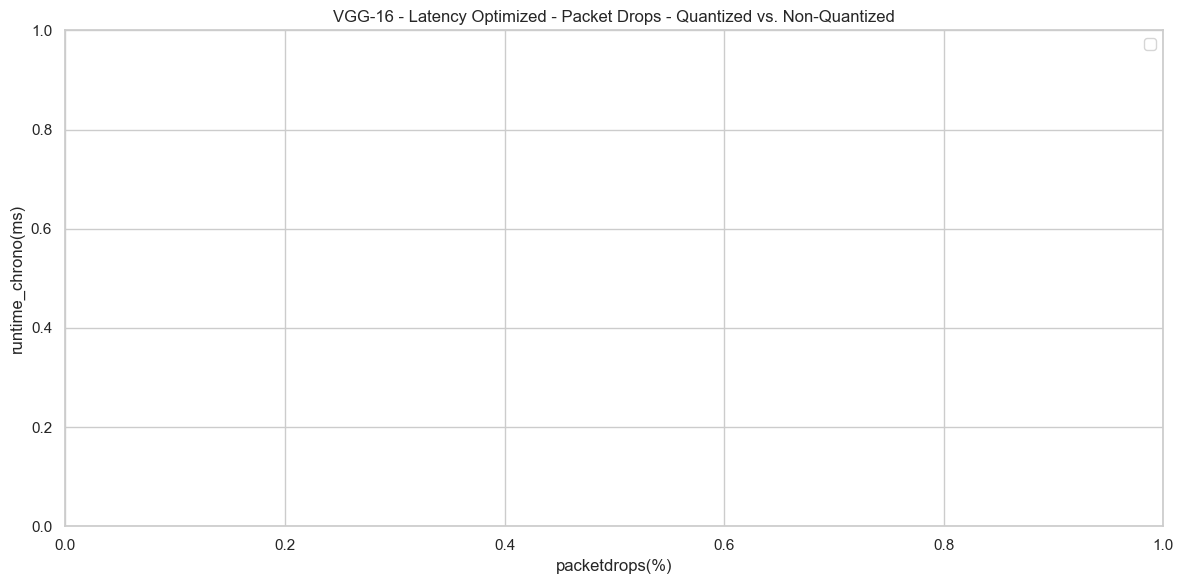

In [219]:

  #  71: "ResNet50 - Bandwidth Optimized",
  #  171: "ResNet50 - Balanced",
  #  271: "ResNet50 - Latency Optimized",
  #  74: "VGG-16 - Bandwidth Optimized",
  #  174: "VGG-16 - Balanced",
  #  274: "VGG-16 - Latency Optimized"
df_band_res_1  = df_band[df_band['Configuration'].str.contains('ResNet50 - Bandwidth Optimized')]
df_band_res_2  = df_band[df_band['Configuration'].str.contains('ResNet50 - Balanced')]
df_band_res_3  = df_band[df_band['Configuration'].str.contains('ResNet50 - Latency Optimized')]
plot_with_std(df_band_res_1, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'ResNet50 - Bandwidth Optimized Bandwidth - Quantized vs. Non-Quantized', 'band_res50_1')
plot_with_std(df_band_res_2, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'ResNet50 - Balanced Bandwidth - Quantized vs. Non-Quantized', 'band_res50_2')
plot_with_std(df_band_res_3, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'ResNet50 - Latency Optimized Bandwidth - Quantized vs. Non-Quantized', 'band_res50_3')

df_band_vgg_1 = df_band[df_band['Configuration'].str.contains('VGG-16 - Bandwidth Optimized')]
df_band_vgg_2 = df_band[df_band['Configuration'].str.contains('VGG-16 - Balanced')]
df_band_vgg_3 = df_band[df_band['Configuration'].str.contains('VGG-16 - Latency Optimized')]
plot_with_std(df_band_vgg_1, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'VGG-16 - Bandwidth Optimized Bandwidth - Quantized vs. Non-Quantized', 'band_vgg16_1')
plot_with_std(df_band_vgg_2, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'VGG-16 - Balanced Bandwidth - Quantized vs. Non-Quantized', 'band_vgg16_2')
plot_with_std(df_band_vgg_3, 'bandwidths(Mbs)', 'runtime_chrono(ms)', 'VGG-16 - Latency Optimized Bandwidth - Quantized vs. Non-Quantized', 'band_vgg16_3')

df_lat_res_1 = df_lat[df_lat['Configuration'].str.contains('ResNet50 - Bandwidth Optimized')]
df_lat_res_2  = df_lat[df_lat['Configuration'].str.contains('ResNet50 - Balanced')]
df_lat_res_3  = df_lat[df_lat['Configuration'].str.contains('ResNet50 - Latency Optimized')]
plot_with_std(df_lat_res_1 , 'latencies(ms)', 'runtime_chrono(ms)', 'ResNet50 - Bandwidth Optimized Latencies - Quantized vs. Non-Quantized', 'lat_res50_1')
plot_with_std(df_lat_res_2 , 'latencies(ms)', 'runtime_chrono(ms)', 'ResNet50 - Balanced - Quantized vs. Non-Quantized', 'lat_res50_2')
plot_with_std(df_lat_res_3 , 'latencies(ms)', 'runtime_chrono(ms)', 'ResNet50 - Latency Optimized- Quantized vs. Non-Quantized', 'lat_res50_3')

# Filter the DataFrame for different VGG-16 configurations
df_lat_vgg_1 = df_lat[df_lat['Configuration'].str.contains('VGG-16 - Bandwidth Optimized')]
df_lat_vgg_2 = df_lat[df_lat['Configuration'].str.contains('VGG-16 - Balanced')]
df_lat_vgg_3 = df_lat[df_lat['Configuration'].str.contains('VGG-16 - Latency Optimized')]
plot_with_std(df_lat_vgg_1, 'latencies(ms)', 'runtime_chrono(ms)', 'VGG-16 - Bandwidth Optimized - Quantized vs. Non-Quantized', 'lat_vgg16_1')
plot_with_std(df_lat_vgg_2, 'latencies(ms)', 'runtime_chrono(ms)', 'VGG-16 - Balanced - Quantized vs. Non-Quantized', 'lat_vgg16_2')
plot_with_std(df_lat_vgg_3, 'latencies(ms)', 'runtime_chrono(ms)', 'VGG-16 - Latency Optimized - Quantized vs. Non-Quantized', 'lat_vgg16_3')



# Filter the DataFrame for different ResNet50 configurations
df_pac_res_1 = df_packet[df_packet['Configuration'].str.contains('ResNet50 - Bandwidth Optimized')]
df_pac_res_2 = df_packet[df_packet['Configuration'].str.contains('ResNet50 - Balanced')]
df_pac_res_3 = df_packet[df_packet['Configuration'].str.contains('ResNet50 - Latency Optimized')]

# Plot packet drops and runtime chronologies for each ResNet50 configuration
plot_with_std(df_pac_res_1, 'packetdrops(%)', 'runtime_chrono(ms)', 'ResNet50 - Bandwidth Optimized - Packet Drops - Quantized vs. Non-Quantized', 'pac_res50_1')
plot_with_std(df_pac_res_2, 'packetdrops(%)', 'runtime_chrono(ms)', 'ResNet50 - Balanced - Packet Drops - Quantized vs. Non-Quantized', 'pac_res50_2')
plot_with_std(df_pac_res_3, 'packetdrops(%)', 'runtime_chrono(ms)', 'ResNet50 - Latency Optimized - Packet Drops - Quantized vs. Non-Quantized', 'pac_res50_3')


# Filter the DataFrame for different VGG-16 configurations
df_pac_vgg_1 = df_packet[df_packet['Configuration'].str.contains('VGG-16 - Bandwidth Optimized')]
df_pac_vgg_2 = df_packet[df_packet['Configuration'].str.contains('VGG-16 - Balanced')]
df_pac_vgg_3 = df_packet[df_packet['Configuration'].str.contains('VGG-16 - Latency Optimized')]

# Plot packet drops and runtime chronologies for each VGG-16 configuration
plot_with_std(df_pac_vgg_1, 'packetdrops(%)', 'runtime_chrono(ms)', 'VGG-16 - Bandwidth Optimized - Packet Drops - Quantized vs. Non-Quantized', 'pac_vgg16_1')
plot_with_std(df_pac_vgg_2, 'packetdrops(%)', 'runtime_chrono(ms)', 'VGG-16 - Balanced - Packet Drops - Quantized vs. Non-Quantized', 'pac_vgg16_2')
plot_with_std(df_pac_vgg_3, 'packetdrops(%)', 'runtime_chrono(ms)', 'VGG-16 - Latency Optimized - Packet Drops - Quantized vs. Non-Quantized', 'pac_vgg16_3')




Table creation

In [237]:
data_frames['bandwidth'].to_csv('bandwidth_fix.csv', index=False)
data_frames['latency'].to_csv('latency_fix.csv', index=False)
data_frames['packet_drop'].to_csv('packet_drop.csv', index=False)

In [245]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def save_mean_std_table_as_image(data, filename="mean_std_table.png", header_suffix="", col_name = 'bandwidths(Mbs)'):

    directory = './stats/tables'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filepath = os.path.join(directory, filename)
    # Calculate mean and standard deviation
    runtime_stats = data.pivot_table(values='runtime_chrono(ms)', index='Combined Configuration', 
                                     columns=col_name, aggfunc=[np.mean, np.std])
    # Format the table with two significant figures for mean and std
    formatted_table = runtime_stats['mean'].round(2).astype(str) + " ± " + runtime_stats['std'].round(2).astype(str)
    
    # Update column headers if suffix is provided
    if header_suffix:
        formatted_table.columns = [str(col) + " " + header_suffix for col in formatted_table.columns]

    # Create a figure and a subplot
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=formatted_table.values, colLabels=formatted_table.columns, rowLabels=formatted_table.index,
                     cellLoc='center', loc='center')  # color example
    
    # Formatting all column headers to bold
    for pos, cell in table.get_celld().items():
        if pos[0] == 0:  # Targeting the first row which is the header row
            cell.set_text_props(fontweight='bold', fontsize=10)
           
        elif pos[0] > 0:  # Applying color to data rows
            if pos[0] % 2 != 1:  # Alternate row coloring, 1-indexed from Matplotlib
                cell.set_facecolor('#e0f8e6')  # Lighter shade of pale green
            


            
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust table scale
    
    # Save the figure
    plt.savefig(filepath, bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
data = pd.read_csv("bandwidth_fix.csv")
save_mean_std_table_as_image(data, "table_band.png", header_suffix="Mbits/ Mean ± Std", col_name= 'bandwidths(Mbs)' )
data = pd.read_csv("latency_fix.csv")
save_mean_std_table_as_image(data, "table_lat.png", header_suffix="ms/ Mean ± Std", col_name= 'latencies(ms)' )
data = pd.read_csv("packet_drop.csv")
save_mean_std_table_as_image(data, "table_pac.png", header_suffix="PacketDrops(%)/ Mean ± Std", col_name= 'packetdrops(%)' )

/var/folders/1l/7grh2yg55rz9z75kz7h_7g5c0000gn/T/ipykernel_75996/994331766.py:12: FutureWarning: The provided callable <function mean at 0x106da25e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  runtime_stats = data.pivot_table(values='runtime_chrono(ms)', index='Combined Configuration',
/var/folders/1l/7grh2yg55rz9z75kz7h_7g5c0000gn/T/ipykernel_75996/994331766.py:12: FutureWarning: The provided callable <function std at 0x106da2700> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  runtime_stats = data.pivot_table(values='runtime_chrono(ms)', index='Combined Configuration',
/var/folders/1l/7grh2yg55rz9z75kz7h_7g5c0000gn/T/ipykernel_75996/994331766.py:12: FutureWarning: The provided callable <function mean at 0x106da25e0> is currentl

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def save_table_as_image(data, filename='table_image.png', col_name = 'bandwidths(Mbs)'):
    directory = './stats/tables'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filepath = os.path.join(directory, filename)
    # First, calculate the percentage improvements as shown in the previous function
    def calculate_percentage_improvement(data):
        grouped_data = data.groupby([col_name, 'Configuration', 'Quantized'])['runtime_chrono(ms)'].mean().unstack()
        grouped_data['Percentage Improvement (Quantized vs Non-Quantized)'] = (
            (grouped_data['Non-Quantized'] - grouped_data['Quantized']) / grouped_data['Non-Quantized'] * 100
        )
        pivot_table = grouped_data.reset_index().pivot(
            index='Configuration', 
            columns=col_name, 
            values='Percentage Improvement (Quantized vs Non-Quantized)'
        )
        return pivot_table
    
    # Generate the pivot table
    pivot_table = calculate_percentage_improvement(data)

    # Plotting the table with seaborn
    plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
    ax = sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Percentage Improvement (%)'})
    plt.title('Percentage Improvement of Quantized Models Over Non-Quantized Models')
    plt.xlabel(col_name)
    plt.ylabel('Configuration')

    # Adjusting the y-labels to be double lined
    ax.set_yticklabels(['\n'.join(label.get_text().split(' - ')) for label in ax.get_yticklabels()])

    # Keeping the y-axis labels horizontal
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)  # Optional: tilt x-axis labels for better fit

    # Saving the plot as an image
    plt.savefig(filepath)
    plt.close()




data = pd.read_csv("bandwidth_fix.csv")
save_table_as_image(data, filename='improvement_BAND.png', col_name='bandwidths(Mbs)')
data = pd.read_csv("latency_fix.csv")
save_table_as_image(data, filename='improvement_lat.png', col_name= 'latencies(ms)')
data = pd.read_csv("packet_drop.csv")
save_table_as_image(data, filename='improvement_pac.png', col_name= 'packetdrops(%)')
